# INTERNSHIP WEEK 2: Hodgkin-Huxley Neuron Model

This notebook uses the sample Python implementation of Hodgkin-Huxley neuron model by Joe Bowen [1].

# Model

** Hodgkin-Huxley Model **  <br>
The Hodking-Huxley Model describes the action potentials of a neuron using a set of non-linear differential equations.

![HHSchematic](http://icwww.epfl.ch/~gerstner/SPNM/img92.gif)
<center>**Figure 2.1** Schematic Diagram of Hodgkin-Huxley Neuron Model [2]</center>

<br>
In Figure 2.1, the neuron model consists of the following components [2]:
* Semipermeable cell membrane / lipid bilayer as a **capacitor**
* Sodium and potassium channels as **time-dependent resistors**
* Leakage channel as **time-independent resistor**
* Injected current as **input current**
* Nernst potential from ion concentration differences as **batteries**

<br>
** Equations ** <br>
The Hodgkin-Huxley Model is *originially* described by the following equations [3]: <br>

<center> 
$I = C_m \frac{dV}{dt} + \overline{g}_{K}n^4(V-E_{K})  + \overline{g}_{Na}m^3h(V-E_{Na})  + \overline{g}_{l}(V-E_{l})$
<center>

where

<center>
$\frac{dn}{dt} = \alpha_n(1-n) - \beta_nn \\
\frac{dm}{dt} = \alpha_m(1-m) - \beta_mm \\
\frac{dh}{dt} = \alpha_h(1-h) - \beta_hh 
$
<center>

and

<center>
$\alpha_n = \frac{0.01 (V+10)}{e^{\frac{V+10}{10}}-1} \qquad
\beta_n = 0.125e^{\frac{V}{80}}$
<center>
<center>
$\alpha_m = \frac{0.1 (V+25)}{e^{\frac{V+25}{10}}-1} \qquad
\beta_m = 4e^{\frac{V}{18}}$
<br>

<center>
$\alpha_h = 0.07 e^{\frac{V}{20}} \qquad
\beta_h = \frac{1}{e^{\frac{V+30}{10}}+1}
$
<center>


# Implementation

The following code implements the HH model with certain set parameter values, and modified $\alpha, \beta$ equations: <br>

* $C_m = 1$ 


* $g_K = 36$
* $g_{Na} = 120$
* $g_L = 0.3$


* $E_K = -77$
* $E_{Na} = 50$
* $E_L = -54.387$


* $\alpha_n = \frac{0.01(V+55)}{1 - e^{-\frac{V+55}{10}}} \qquad
\beta_n = 0.125e^{-\frac{V+65}{80}}
$


* $\alpha_m = \frac{0.1(V+40)}{1 - e^{-\frac{V+40}{10}}} \qquad
\beta_m = 4e^{-\frac{V+65}{18}}
$


* $\alpha_h = 0.07e^{-\frac{V+65}{20}} \qquad
\beta_h = \frac{1}{1 + e^{-\frac{V+35}{10}}}
$


( These changes in $\alpha, \beta$ equations are still unknown at this point )

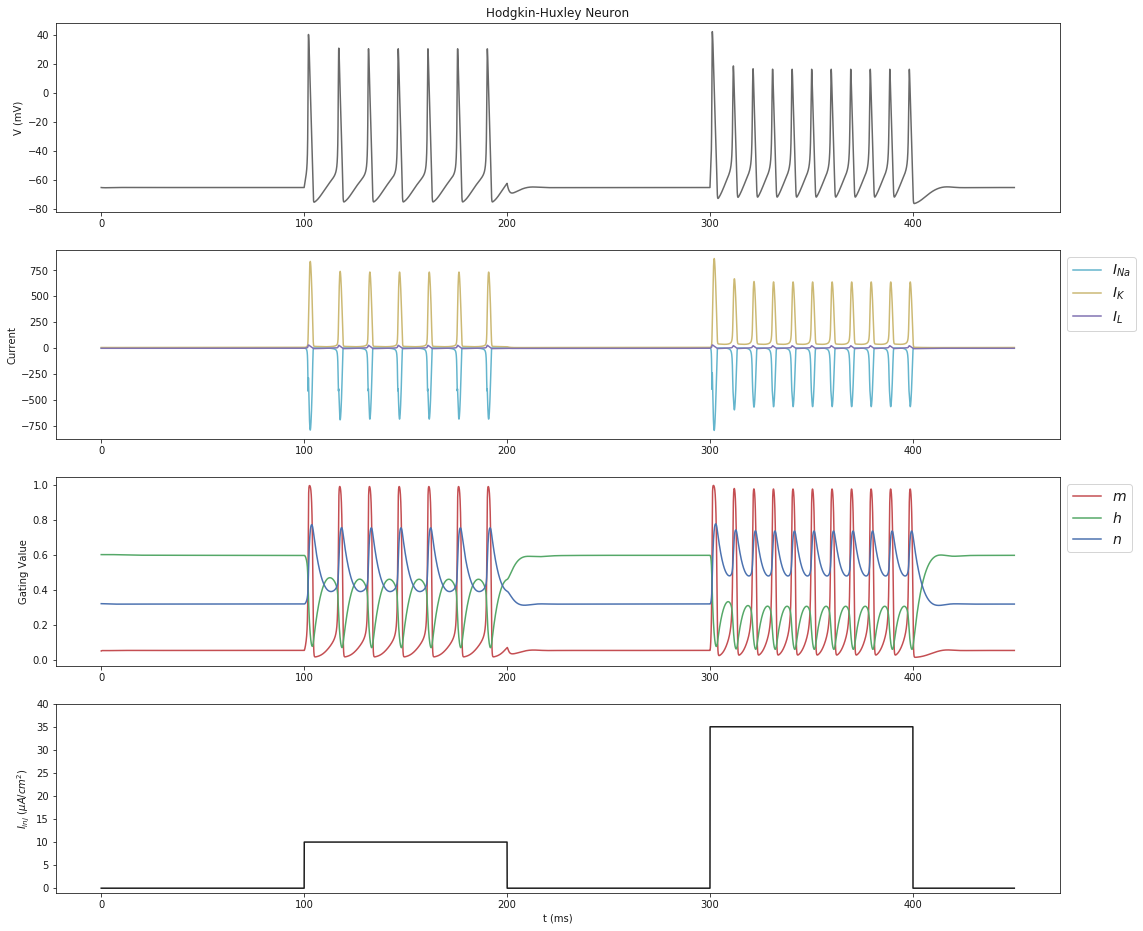

In [5]:
import scipy as sp
import pylab as plt
import seaborn as sns

from scipy.integrate import odeint

cp = sns.color_palette("hls", 7)
sns.set_palette(cp)
sns.set_color_codes()

class HodgkinHuxley():
    """Full Hodgkin-Huxley Model implemented in Python"""

    C_m  =   1.0
    """membrane capacitance, in uF/cm^2"""

    g_Na = 120.0
    """Sodium (Na) maximum conductances, in mS/cm^2"""

    g_K  =  36.0
    """Postassium (K) maximum conductances, in mS/cm^2"""

    g_L  =   0.3
    """Leak maximum conductances, in mS/cm^2"""

    E_Na =  50.0
    """Sodium (Na) Nernst reversal potentials, in mV"""

    E_K  = -77.0
    """Postassium (K) Nernst reversal potentials, in mV"""

    E_L  = -54.387
    """Leak Nernst reversal potentials, in mV"""

    t = sp.arange(0.0, 450.0, 0.01)
    """ The time to integrate over """

    def alpha_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.1*(V+40.0)/(1.0 - sp.exp(-(V+40.0) / 10.0))

    def beta_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 4.0*sp.exp(-(V+65.0) / 18.0)

    def alpha_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.07*sp.exp(-(V+65.0) / 20.0)

    def beta_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 1.0/(1.0 + sp.exp(-(V+35.0) / 10.0))

    def alpha_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.01*(V+55.0)/(1.0 - sp.exp(-(V+55.0) / 10.0))

    def beta_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.125*sp.exp(-(V+65) / 80.0)

    def I_Na(self, V, m, h):
        """
        Membrane current (in uA/cm^2)
        Sodium (Na = element name)

        |  :param V:
        |  :param m:
        |  :param h:
        |  :return:
        """
        return self.g_Na * m**3 * h * (V - self.E_Na)

    def I_K(self, V, n):
        """
        Membrane current (in uA/cm^2)
        Potassium (K = element name)

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_K  * n**4 * (V - self.E_K)

    #  Leak
    def I_L(self, V):
        """
        Membrane current (in uA/cm^2)
        Leak

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_L * (V - self.E_L)

    def I_inj(self, t):
        """
        External Current

        |  :param t: time
        |  :return: step up to 10 uA/cm^2 at t>100
        |           step down to 0 uA/cm^2 at t>200
        |           step up to 35 uA/cm^2 at t>300
        |           step down to 0 uA/cm^2 at t>400
        """
        return 10*(t>100) - 10*(t>200) + 35*(t>300) - 35*(t>400)

    @staticmethod
    def dALLdt(X, t, self):
        """
        Integrate

        |  :param X:
        |  :param t:
        |  :return: calculate membrane potential & activation variables
        """
        V, m, h, n = X

        dVdt = (self.I_inj(t) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
        dmdt = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
        dhdt = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
        dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        return dVdt, dmdt, dhdt, dndt

    def Main(self):
        """
        Main demo for the Hodgkin Huxley neuron model
        """

        X = odeint(self.dALLdt, [-65, 0.05, 0.6, 0.32], self.t, args=(self,))
        V = X[:,0]
        m = X[:,1]
        h = X[:,2]
        n = X[:,3]
        ina = self.I_Na(V, m, h)
        ik = self.I_K(V, n)
        il = self.I_L(V)

        plt.figure(figsize=(18, 16))

        ax1 = plt.subplot(4,1,1)
        plt.title('Hodgkin-Huxley Neuron')
        plt.plot(self.t, V, 'dimgrey')
        plt.ylabel('V (mV)')
        
#         import numpy as np
#         np.set_printoptions(threshold='nan')
#         print np.array(V)
        
        ax2 = plt.subplot(4,1,2, sharex=ax1)
        plt.plot(self.t, ina, 'c', label='$I_{Na}$') #c
        plt.plot(self.t, ik, 'y', label='$I_{K}$') #y
        plt.plot(self.t, il, 'm', label='$I_{L}$') #m
        plt.ylabel('Current')
        plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5, prop={'size': 14})
        
        ax3 = plt.subplot(4,1,3, sharex=ax1)
        plt.plot(self.t, m, 'r', label='$m$') #r
        plt.plot(self.t, h, 'g', label='$h$') #g
        plt.plot(self.t, n, 'b', label='$n$') #b
        plt.ylabel('Gating Value')
        plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5, prop={'size': 14})
        
        ax4 = plt.subplot(4,1,4, sharex=ax1)
        i_inj_values = [self.I_inj(t) for t in self.t]
        plt.plot(self.t, i_inj_values, 'k')
        plt.xlabel('t (ms)')
        plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
        plt.ylim(-1, 40)

        plt.show()

if __name__ == '__main__':
    runner = HodgkinHuxley()
    runner.Main()

The plots above show the membrane potential (voltage), ionic current, and ion gates value of the neuron when injected with a current $I_{inj}$.

From these plots, we can observe the following:

* Injecting a current ***results to a voltage spike*** in the neuron
* Longer time interval of injected current ***produces more spikes***
* Higher amplitude of injected current ***increases the frequency of spikes***


* Potassium ionic current ***$I_{K}$ increases*** (in spikes) with injected current
* Similarly, the ionic gate value ***$n$*** for potassium ***increases*** as well, which corresponds to activation


* Sodium ionic current ***$I_{Na}$ decreases*** (in spikes) with injected current
* Similarly, the ionic gate value ***$m$*** for sodium ***increases***, which corresponds to activation
* While ***$h$ decreases***, which corresponds to inactivation

# References

[1] Bowen, J. (2014). *Hodgkin Huxley Sources*. Retrieved October 13, 2017, from http://hodgkin-huxley-tutorial.readthedocs.io/en/latest/_static/Hodgkin%20Huxley.html <br>
[2] Gerstner , W., & Kistler, W. (2002). *Hodgkin-Huxley Model*. Retrieved October 13, 2017, from http://icwww.epfl.ch/~gerstner/SPNM/node14.html <br>
[3] Hodgkin, A., and Huxley, A. (1952). *A Quantitave Description of Membrane Current and Its Application to Conduction and Exctitation in Nerve.*

---
`Document Created: 13 October 2017` <br>
`Author: Paul Rossener Regonia`